In [1]:
%reload_ext autoreload
%autoreload 2

import os
import torch
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path
from scipy import interpolate
from sklearn.preprocessing import normalize

# make x and y be a function of t
# t is the total distance traveled


def get_strokes(path, max_stroke_count=None):
    """
    Args:
        path: XML path to stroke file

    Returns:
        list of lists of dicts: each dict contains a stroke, keys: x,y, time
    """
    root = ET.parse(path).getroot()
    all_strokes = root[1]
    stroke_lists = []
    start_end_strokes_lists = []

    # If not constrained by number of strokes, set max_stroke_count to full length window
    if max_stroke_count is None:
        max_stroke_count = len(all_strokes) - 1
    
    for i in range(len(all_strokes) - max_stroke_count):
        strokes = all_strokes[i:i + max_stroke_count]
        stroke_list = []
        min_time = float(strokes[0][0].attrib["time"])
        last_time = 0
        stroke_delay = 0  # time between strokes
        start_end_strokes = [] # list of start times and end times between strokes; one before sequence starts!
        
        for stroke in strokes:
            x_coords = []
            y_coords = []
            time_list = []

            for i, point in enumerate(stroke):
                # print("Points", len(strokes))
                x, y, time = point.attrib["x"], point.attrib["y"], point.attrib["time"]
                x_coords.append(int(x))
                y_coords.append(-int(y))

                if i == 0:  # no time passes between strokes!
                    min_time += float(time) - min_time - last_time - .001
                    start_end_strokes.append((last_time, float(time) - min_time))

                next_time = float(time) - min_time

                if time_list and next_time == time_list[-1]:
                    next_time += .001
                    assert next_time > time_list[-1]

                # No repeated times
                if time_list and next_time <= time_list[-1]:
                    next_time = time_list[-1] + .001

                time_list.append(next_time)
            last_time = time_list[-1]
            stroke_list.append({"x": x_coords, "y": y_coords, "time": time_list})

        stroke_lists.append(stroke_list)
        start_end_strokes_lists.append(start_end_strokes)
        
    return stroke_lists, start_end_strokes_lists

def convert_strokes(stroke_list):
    x, y, time = [], [], []
    [x.extend(key["x"]) for key in stroke_list]
    [y.extend(key["y"]) for key in stroke_list]
    [time.extend(key["time"]) for key in stroke_list]
    return np.array(x), np.array(y), np.array(time)

def process(time):
    total_time = np.max(time) - np.min(time)


In [2]:
def normalize(my_array):
    return ((my_array-np.min(my_array))/(np.max(my_array)-np.min(my_array))-.5)*2

def get_gts(path, instances = 50):
    stroke_list, start_end_strokes = get_strokes(path)
    x,y,time = convert_strokes(stroke_list)

    # find dead timezones
    # make x and y independently a function of t
    time_continuum = np.linspace(np.min(time), np.max(time), instances)
    x_func = interpolate.interp1d(time, x)
    y_func = interpolate.interp1d(time, y)

    for i,t in enumerate(time_continuum):
        for lower, upper in start_end_strokes:
            if t < lower:
                break
            if t > lower and t < upper:
                t = lower if abs(t-lower)<abs(t-upper) else upper
                time_continuum[i] = t
                break
    return normalize(x_func(time_continuum)), normalize(y_func(time_continuum))


In [8]:
path = Path("../data/prepare_online_data/line-level-xml/lineStrokes/a01/a01-000/a01-000u-01.xml")

get_gts(path)

TypeError: list indices must be integers or slices, not str

In [9]:
def extract_gts(path, instances = 50, max_stroke_count=None):
    """ Take in xml with strokes, output ordered target coordinates
        Parameterizes x & y coordinates as functions of t
        Any t can be selected; strokes are collapsed so there's minimal time between strokes

        Start stroke flag - true for first point in stroke
        End stroke flag - true for last point in stroke
        ** A single point can have both flags!

    Args:
        path (str): path to XML
        instances (int): number of desired coordinates

    Returns:
        x-array, y-array
    """
    stroke_lists, start_end_strokes_lists = get_strokes(path, max_stroke_count=max_stroke_count)
    
    output_gts = []
    output_stroke_lists = []
    output_xs_to_ys = []
    print(stroke_lists)
    print(start_end_strokes_lists)
    for stroke_list, start_end_strokes in zip(stroke_lists, start_end_strokes_lists):
        x,y,time = convert_strokes(stroke_list)

        # find dead timezones
        # make x and y independently a function of t
        time_continuum = np.linspace(np.min(time), np.max(time), instances)
        x_func = interpolate.interp1d(time, x)
        y_func = interpolate.interp1d(time, y)
        
        
def pen_up_motions():
    pass

In [10]:
extract_gts(path)

[[{'x': [1073, 1072, 1066, 1052, 1030, 1009, 994, 980, 971, 968, 966, 972, 978, 991, 1003, 1016, 1021, 1030, 1040, 1049, 1055, 1058, 1064, 1071, 1071, 1074, 1083, 1097, 1114, 1134, 1158, 1181, 1200, 1218, 1220, 1223, 1221, 1220, 1215, 1204], 'y': [-1058, -1085, -1117, -1152, -1196, -1242, -1286, -1317, -1336, -1344, -1339, -1340, -1320, -1298, -1266, -1231, -1184, -1143, -1108, -1077, -1049, -1021, -1006, -1006, -1006, -1013, -1042, -1082, -1124, -1172, -1225, -1280, -1327, -1365, -1373, -1376, -1372, -1369, -1353, -1330], 'time': [0.0009999999999763531, 0.02100000000007185, 0.031000000000062755, 0.051000000000044565, 0.07100000000002638, 0.08100000000001728, 0.09100000000000819, 0.11099999999999, 0.1309999999999718, 0.1410000000000764, 0.1510000000000673, 0.1710000000000491, 0.19100000000003092, 0.20100000000002183, 0.22100000000000364, 0.23099999999999454, 0.25099999999997635, 0.26099999999996726, 0.28100000000006276, 0.29100000000005366, 0.31100000000003547, 0.3210000000000264, 0.33

In [213]:
import sys
sys.path.append("../")
from hwr_utils.stroke_recovery import plot_stroke_points, prep_figure, sample, prep_stroke_dict, read_stroke_xml, get_all_substrokes
from hwr_utils.stroke_plotting import plot_stroke_points


In [221]:
path = Path("../data/prepare_online_data/line-level-xml/lineStrokes/a01/a01-000/a01-000u-01.xml")
strokes, start_times = read_stroke_xml(path)
prepped_stroke_dict = prep_stroke_dict(strokes, time_interval=0)
function_x, function_y = create_functions_from_strokes(prepped_stroke_dict)

# print(function_x(prepped_stroke_dict.start_times))
# print(function_y(prepped_stroke_dict.start_times))
# print(new_start_times)
prepped_stroke_dict.start_strokes

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [236]:
print(prepped_stroke_dict.start_times)
print(np.where(prepped_stroke_dict.start_strokes==1))
for x in get_all_substrokes(prepped_stroke_dict):
    print(x)


[ 0.          1.67133283  2.23788639  4.39078967  5.35393066  6.373727
  7.62014472  7.98840457  8.63994115  8.83823495  9.5180992  10.48124019
 10.87782771 11.04779383 11.69933041 12.86076512 14.78704701 15.55189428
 15.97680947 17.39319324 17.61981472 18.63961105 18.86623253 18.97954331
 19.51776919 19.74439067 20.56589329 20.99080848 21.72732808 22.29388164
 22.71879683 23.20036728]
(array([  0,  40,  54, 105, 128, 153, 183, 192, 208, 214, 231, 253, 263,
       268, 284, 312, 358, 377, 388, 422, 428, 453, 459, 463, 476, 482,
       502, 513, 531, 545, 556, 568]),)
[  0  40  54 105 128 153 183 192 208 214 231 253 263 268 284 312 358 377
 388 422 428 453 459 463 476 482 502 513 531 545 556 568]
{'x': array([0.28918919, 0.28648649, 0.27027027, 0.23243243, 0.17297297,
       0.11621622, 0.07567568, 0.03783784, 0.01351351, 0.00540541,
       0.        , 0.01621622, 0.03243243, 0.06756757, 0.1       ,
       0.13513514, 0.14864865, 0.17297297, 0.2       , 0.22432432,
       0.24054054, 0.

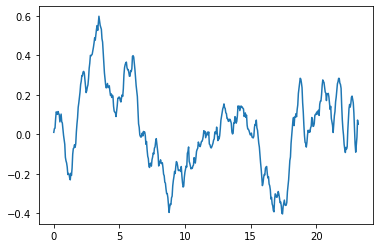

(-0.4683001050871485,
 9.884558811441273,
 -0.047545560443184504,
 1.0506474515839777)

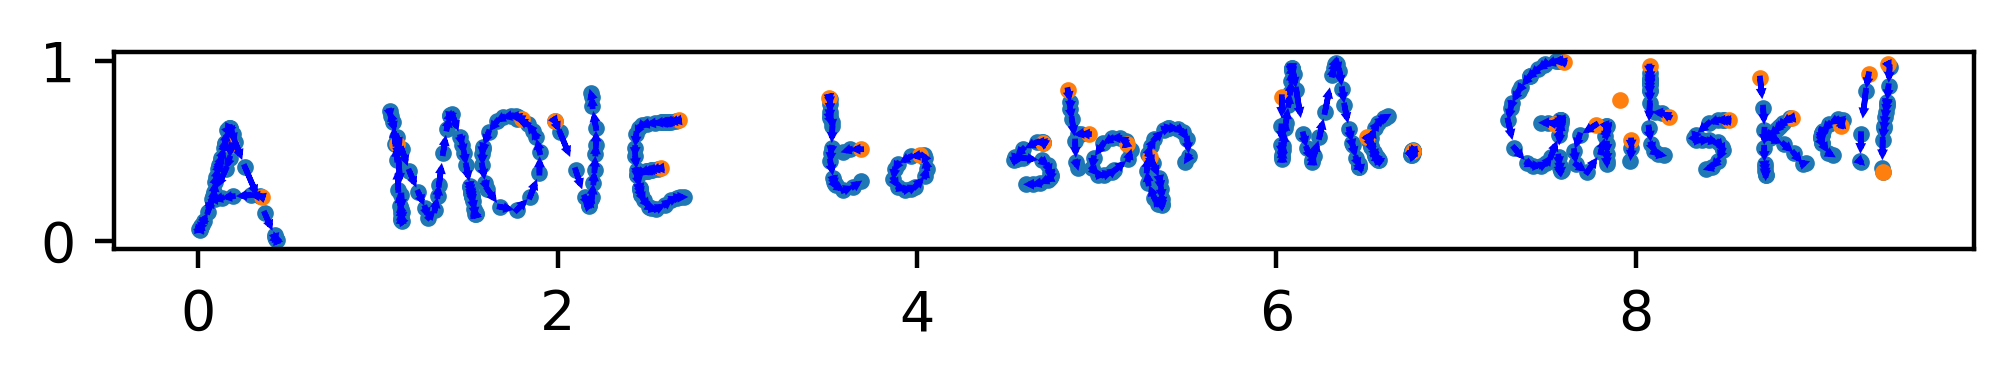

In [206]:
#plt.figure(dpi=300)
x,y,starts = sample(function_x, function_y, new_start_times, 500, noise="lagged", plot=True)

#plot_stroke_points(x[:10],y[:10],starts[:10])

size = 5,1
dpi = 400
#plt.figure(figsize=size, dpi=dpi)
plt.figure(dpi=dpi)

#prep_figure(dpi=300, size=(3,1))
plot_stroke_points(x,y,starts)
plt.axis('scaled')
#plt.axis('off')


In [191]:
import pickle
path = Path('./pickle.pickle')
pickle.dump(function_x, path.open("w"))


TypeError: write() argument must be str, not bytes

In [209]:
x = np.array([0,1,0,1,1])
np.where(x==1)

(array([1, 3, 4]),)

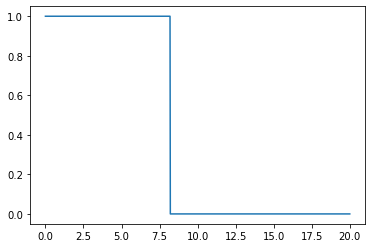

In [154]:
x_space = np.linspace(0,20,1000)
plt.plot(x_space, stroke_down_func(x_space))

In [155]:
print(starts)

[0.0, 0.59, 0.7899999999999998, 1.5499999999999998, 1.8899999999999997, 2.2499999999999996, 2.69, 2.82, 3.0499999999999994, 3.12, 3.3600000000000003, 3.700000000000001, 3.8400000000000016, 3.900000000000002, 4.130000000000003, 4.540000000000003, 5.220000000000002, 5.490000000000002, 5.640000000000002, 6.140000000000002, 6.220000000000002, 6.580000000000002, 6.660000000000004, 6.700000000000006, 6.890000000000004, 6.970000000000006, 7.260000000000005, 7.410000000000007, 7.670000000000009, 7.870000000000008, 8.020000000000007, 8.190000000000008]


In [140]:
distance_metric = lambda x,y: ((x[:-1] - x[1:])**2 + (y[:-1] - y[1:])**2)**(1/2)
distance = 0
stroke_dict = {"x": range(0,9), "y":range(0,9)}
# Loop through each stroke
xs = np.asarray(stroke_dict["x"])
ys = np.asarray(stroke_dict["y"])
distance += np.sum(distance_metric(xs,ys))
print(distance)

(8**2+8**2)**(1/2)

11.313708498984761


11.313708498984761